# 📈 From ARIMA to SARIMA ⏳: Handling Seasonality in Time Series 🌦️

### Quick Recap of ARIMA

ARIMA = Auto-Regressive + Integrated + Moving Average

Works well for stationary series.

Limitation: Cannot naturally handle seasonality.

👉 Example to show: A sales dataset with clear monthly or weekly repeating patterns where ARIMA struggles.

### Introduce Seasonality

Define seasonality: Regular, repeating patterns at fixed intervals (daily, weekly, yearly).

Show a plot with clear seasonal spikes (e.g., ice cream sales peaking every summer).

### Why ARIMA Fails on Seasonal Data

ARIMA tries to fit seasonality as noise → results in poor forecasts.

Show ARIMA predictions missing seasonal peaks.

💡 Key Message: ARIMA is powerful, but not seasonal-aware.

### SARIMA as an Extension

SARIMA = Seasonal ARIMA = ARIMA + Seasonal Terms

Formula: SARIMA(p,d,q)(P,D,Q,m)

Non-seasonal part: (p,d,q) → same as ARIMA

Seasonal part: (P,D,Q,m)

P = seasonal autoregression

D = seasonal differencing

Q = seasonal moving average

m = length of season (e.g., 12 for monthly, 7 for weekly)

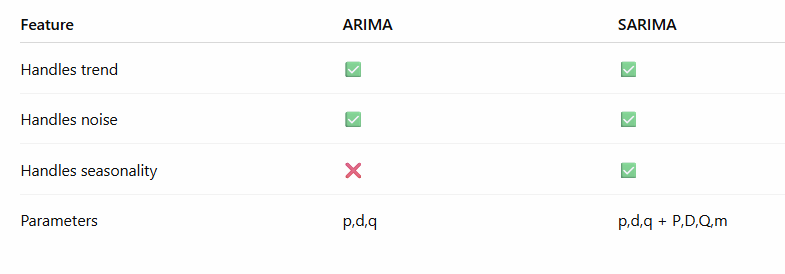

# 📊 Forecasting Daily Retail Orders with SARIMA: Modeling Weekly Seasonality for Smarter Inventory Planning

### 🏪 Business Problem

A retail company receives hundreds of customer orders every day. The operations team has observed that order volumes are not random — they follow a weekly cycle:

📈 Orders spike toward the end of the week (e.g., Fridays).

📉 Orders dip at the start of the week (e.g., Mondays).

Previously, the company used a basic ARIMA model. While it captured the average demand, it produced a flat forecast line, missing the weekly up-and-down pattern.

This limitation made it difficult for managers to:

Plan inventory replenishment efficiently.

Schedule warehouse staff according to high and low demand days.

Reduce stock-outs on peak days and overstock on slow days.

To address this, we will apply Seasonal ARIMA (SARIMA), which explicitly models weekly seasonality (7-day cycle). This will provide more realistic forecasts that reflect the true demand pattern, enabling data-driven operational planning.

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Step 1: Load dataset with correct delimiter

In [28]:
url = "Daily_Demand_Forecasting_Orders.csv"
df = pd.read_csv(url, sep=";")  # semicolon-separated file

In [29]:
df.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


### Step 2: Clean column names (remove spaces, special chars)

In [30]:
df.columns = (
    df.columns
      .str.strip()
      .str.replace(" ", "_", regex=False)
      .str.replace("(", "", regex=False)
      .str.replace(")", "", regex=False)
      .str.replace(";", "", regex=False)
)

print("Columns after cleaning:", df.columns.tolist())


Columns after cleaning: ['Week_of_the_month_first_week,_second,_third,_fourth_or_fifth_week', 'Day_of_the_week_Monday_to_Friday', 'Non-urgent_order', 'Urgent_order', 'Order_type_A', 'Order_type_B', 'Order_type_C', 'Fiscal_sector_orders', 'Orders_from_the_traffic_controller_sector', 'Banking_orders_1', 'Banking_orders_2', 'Banking_orders_3', 'Target_Total_orders']


In [31]:
df.head()

,"Week_of_the_month_first_week,_second,_third,_fourth_or_fifth_week",Day_of_the_week_Monday_to_Friday,Non-urgent_order,Urgent_order,Order_type_A,Order_type_B,Order_type_C,Fiscal_sector_orders,Orders_from_the_traffic_controller_sector,Banking_orders_1,Banking_orders_2,Banking_orders_3,Target_Total_orders
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


### Step 3: Add date index (simulate daily dates)

In [32]:
len(df)

60

In [33]:
df['Date'] = pd.date_range(start='2025-06-01', periods=len(df), freq='D')
df.set_index('Date', inplace=True)

In [34]:
df.head()

,"Week_of_the_month_first_week,_second,_third,_fourth_or_fifth_week",Day_of_the_week_Monday_to_Friday,Non-urgent_order,Urgent_order,Order_type_A,Order_type_B,Order_type_C,Fiscal_sector_orders,Orders_from_the_traffic_controller_sector,Banking_orders_1,Banking_orders_2,Banking_orders_3,Target_Total_orders
Date,,,,,,,,,,,,,
2025-06-01,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
2025-06-02,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2025-06-03,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
2025-06-04,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
2025-06-05,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


### Step 4: Target series = Total Orders

In [36]:
ts.head()

Date
2025-06-01    539.577
2025-06-02    224.675
2025-06-03    129.412
2025-06-04    317.120
2025-06-05    210.517
Freq: D, Name: Target_Total_orders, dtype: float64

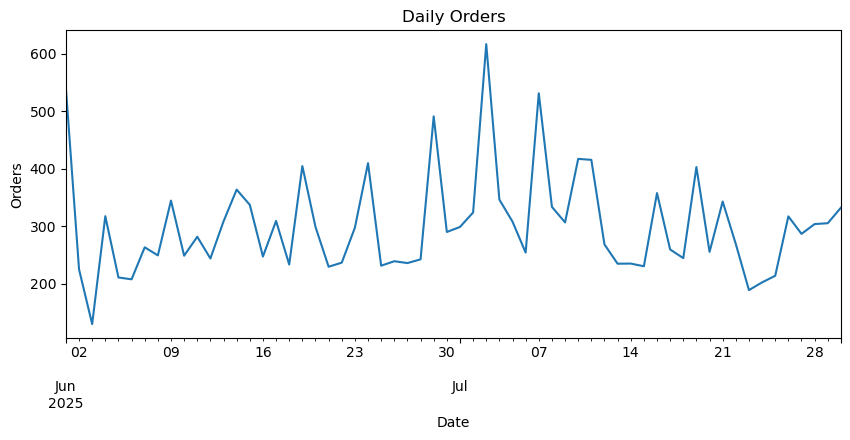

In [8]:

ts = df['Target_Total_orders']

ts.plot(figsize=(10,4), title="Daily Orders")

plt.ylabel("Orders")
plt.show()

### Step 5: Stationarity test

In [37]:
adf_result = adfuller(ts)
print("ADF Statistic: %.3f, p-value: %.3f" % (adf_result[0], adf_result[1]))
# Even if non-stationary, SARIMA handles it with differencing

ADF Statistic: -7.495, p-value: 0.000


### Step 6: Fit SARIMA (weekly seasonality, m=7)


In [38]:
# order = (p,d,q), seasonal_order = (P,D,Q,m)
# We'll start with SARIMA(1,1,1)(1,1,1,7)
# Ensure datetime index has frequency
ts = ts.asfreq('D')   # 'D' = daily, 'W' = weekly, 'M' = monthly etc.

# Now fit SARIMA
model = sm.tsa.SARIMAX(ts,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
results = model.fit()
print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:               Target_Total_orders   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -260.488
Date:                           Wed, 27 Aug 2025   AIC                            530.977
Time:                                   11:09:38   BIC                            539.783
Sample:                               06-01-2025   HQIC                           534.224
                                    - 07-30-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0119      0.200     -0.059      0.953      -0.404       0.380
ma.L1         -0.8283      0.137     -6.066

### Observation 

AIC and BIC are information criteria — the lower their values, the better the model balances fit and complexity.

### Step 7: Diagnostics


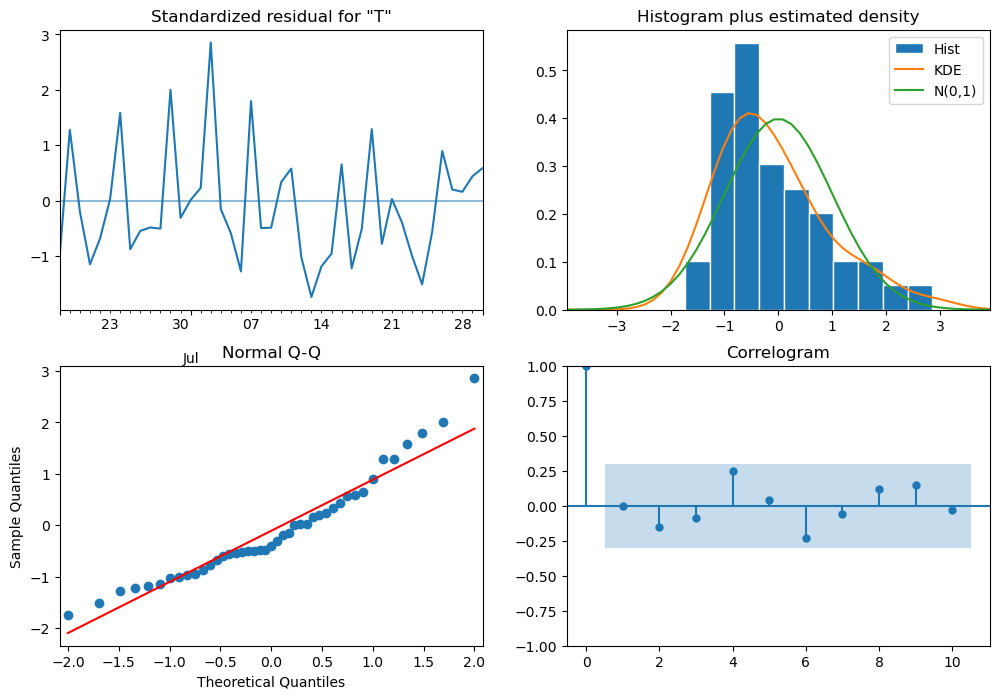

In [39]:
results.plot_diagnostics(figsize=(12,8))
plt.show()


### Observation

🔹 Top-Left (Standardized Residuals):

👉 “Residuals bounce randomly around zero, which means the model has captured most patterns.”

🔹 Top-Right (Histogram + KDE):

👉 “Residuals are roughly bell-shaped, so errors look close to normal distribution.”

🔹 Bottom-Left (Normal Q-Q):

👉 “Points lie close to the red line, showing residuals follow normality fairly well.”

🔹 Bottom-Right (Correlogram):

👉 “No significant spikes outside the blue band, so residuals are not autocorrelated.”

### Step 8: Forecast next 30 days

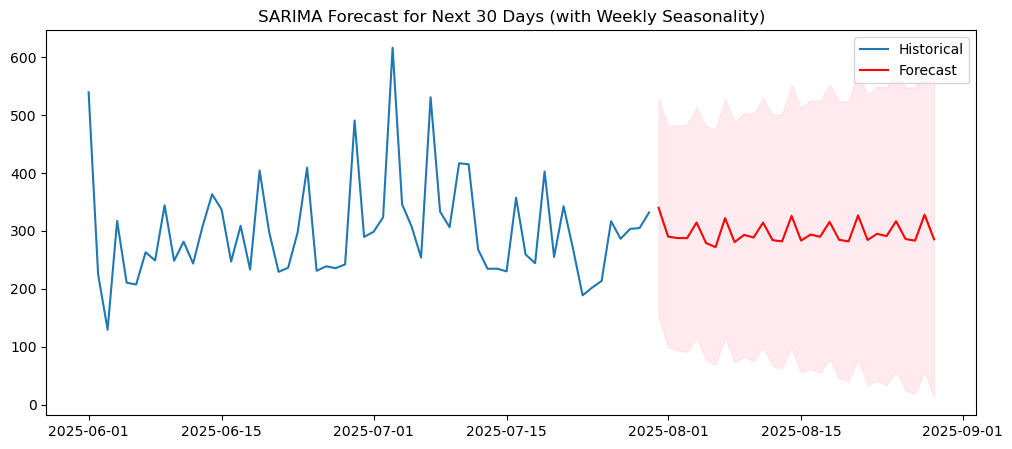

In [40]:

forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame()

# Plot forecast
plt.figure(figsize=(12,5))
plt.plot(ts, label="Historical")
plt.plot(forecast_df.index, forecast_df['mean'], label="Forecast", color="red")
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color="pink", alpha=0.3)
plt.legend()
plt.title(f"SARIMA Forecast for Next {forecast_steps} Days (with Weekly Seasonality)")
plt.show()

### Observation

🔹 The blue line shows our historical data, while the red line is the SARIMA forecast for the next 30 days.

🔹 We can see the forecast continues with a weekly seasonal pattern, as expected.

🔹 The shaded area is the confidence interval — it shows the possible range of future values, wider means more uncertainty.

### Step 9: Backtesting on last 15 days

In [41]:
# Split data
train, test = ts[:-15], ts[-15:]

# Re-assign frequency (assuming daily data)
train = train.asfreq('D')
test  = test.asfreq('D')

# Build SARIMA model
model_bt = sm.tsa.SARIMAX(train,
                          order=(1,1,1),
                          seasonal_order=(1,1,1,7),
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_bt = model_bt.fit()
pred_bt = results_bt.forecast(steps=15)


### Error metrics

In [42]:

mae = mean_absolute_error(test, pred_bt)
rmse = np.sqrt(mean_squared_error(test, pred_bt))
mape = np.mean(np.abs((test - pred_bt) / test)) * 100
print(f"Backtest → MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


Backtest → MAE: 100.65, RMSE: 138.22, MAPE: 41.46%


### Step 10: Human-readable summary

In [43]:
print("\n=== Forecast Summary ===")
print("Model: SARIMA(1,1,1)(1,1,1,7)")
print(f"Forecast horizon: next {forecast_steps} days")
print(f"First day forecast: {forecast_df['mean'].iloc[0]:.0f} orders "
      f"(range {forecast_df['mean_ci_lower'].iloc[0]:.0f} – {forecast_df['mean_ci_upper'].iloc[0]:.0f})")


=== Forecast Summary ===
Model: SARIMA(1,1,1)(1,1,1,7)
Forecast horizon: next 30 days
First day forecast: 340 orders (range 151 – 529)


### Step 11: Backtest

In [44]:
# Split data
train, test = ts[:-forecast_steps], ts[-forecast_steps:]

# Re-assign frequency (assuming daily data)
train = train.asfreq('D')
test  = test.asfreq('D')

# ARIMA model

model_bt = sm.tsa.ARIMA(train, order=(1,1,1))
results_bt = model_bt.fit()
pred_bt = results_bt.forecast(steps=forecast_steps)

# Metrics

mae = mean_absolute_error(test, pred_bt)
rmse = np.sqrt(mean_squared_error(test, pred_bt))
mape = np.mean(np.abs((test - pred_bt) / test)) * 100

print(f'Backtest → MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')


Backtest → MAE: 65.46, RMSE: 94.70, MAPE: 19.54%


### Observation

Backtesting isn’t just about one score — it helps us see how stable the model is across different time periods.

### Summary

👉 SARIMA not only captures trend and randomness like ARIMA, but also models repeating seasonal patterns.

👉 With it, we can generate realistic forecasts along with uncertainty bands, making the model more useful for business decisions.